GENERATING RESOLUTION COMPARISON

Generating image with 5,000 points...
Image saved as: modelo_5000pts_lat50_lon180_rad10.png

Generating image with 60,000 points...
Image saved as: modelo_60000pts_lat50_lon180_rad10.png

Generating image with 90,000 points...
Image saved as: modelo_90000pts_lat50_lon180_rad10.png

CREATING COMPARISON FIGURE


/var/folders/q8/yvk_kx2x789_cz2jkdkx2mzh0000gn/T/ipykernel_29388/1818778675.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


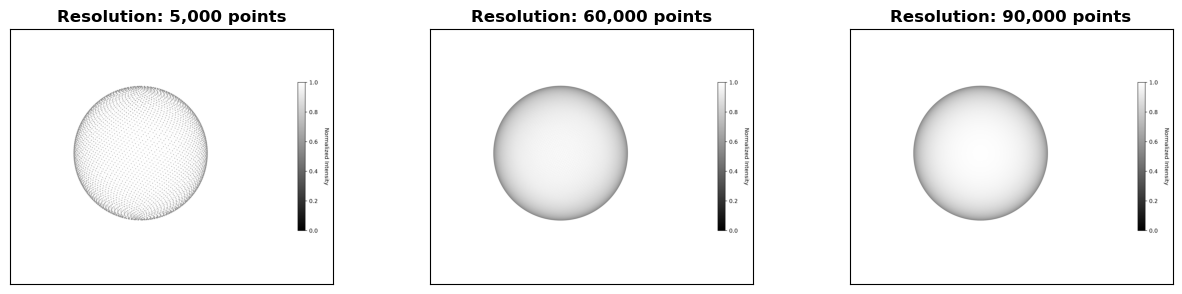


Comparison saved as: resolution_comparison_lat50_lon180_rad10.png

RESOLUTION QUALITY ANALYSIS

Resolution 5,000 points:
  - Image dimensions: 2824×2226
  - Mean intensity: 250.83
  - Contrast: 0.091
  - Entropy: 0.739 (higher = more information)

Resolution 60,000 points:
  - Image dimensions: 2824×2226
  - Mean intensity: 248.61
  - Contrast: 0.097
  - Entropy: 1.550 (higher = more information)

Resolution 90,000 points:
  - Image dimensions: 2824×2226
  - Mean intensity: 249.06
  - Contrast: 0.095
  - Entropy: 1.530 (higher = more information)

Metrics saved as: resolution_metrics.csv

PROCESS COMPLETED!
Individual images generated:
  - modelo_5000pts_lat50_lon180_rad10.png
  - modelo_60000pts_lat50_lon180_rad10.png
  - modelo_90000pts_lat50_lon180_rad10.png
Comparison figure: resolution_comparison_lat50_lon180_rad10.png
Detailed metrics: resolution_metrics.csv


In [17]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
import os
from PIL import Image
import glob
import matplotlib.gridspec as gridspec

os.makedirs("frames", exist_ok=True)

# ---- fibonacci sphere ----
def fibonacci_sphere(n_points):
    """Generating equal points distributed on a sphere"""
    indices = np.arange(n_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n_points)  # [0, π]
    theta = np.pi * (1 + 5**0.5) * indices  # golden angle
    
    return phi, theta % (2*np.pi)  # values between 0 and 2π

def cartesian_from_spherical(phi, theta, r=1.0):
    """Convert spherical coordinates to cartesian"""
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return x, y, z

def spot_mask_geodesic(x, y, z, spot_center, spot_radius_rad):
    """Mask using real geodesic distance with optimization"""
    # Convert the spot_center vector to a unit vector (of length 1)
    center_norm = spot_center / np.linalg.norm(spot_center)
    
    # Dot product
    positions = np.stack([x, y, z], axis=-1)
    norms = np.linalg.norm(positions, axis=-1, keepdims=True)
    pos_norm = positions / np.clip(norms, 1e-10, None)     
    dot_product = np.sum(pos_norm * center_norm, axis=-1) 
    dot_product = np.clip(dot_product, -1, 1) 
    
    # central_angle is the geodesic distance (in radians)
    central_angle = np.arccos(dot_product)
    
    return np.exp(-(central_angle**2) / (2 * spot_radius_rad**2))

def spot_theta(rotation_period, spot_colatitude, relative_shear):
    ''' Parameters:
    - rotation_period: rotation period of the star
    - spot_colatitude: spot colatitude (radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity '''
    
    latitude = np.pi / 2 - spot_colatitude
    angular_vel_equa = 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity

def quadratic(u1, u2, mu):
    return 1 - u1*(1 - mu) - u2*(1 - mu)**2
    
def create_spot(latitude_deg, longitude_deg, radii_deg, rotation_period):
    """Create a spot dictionary"""
    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.015)  
    
    return {
        'theta': longitude_rad * u.rad,
        'phi': colatitude_rad,
        'radius': radii_rad,
        'angular_velocity': ang_vel
    }

def generate_star_image(n_points, theta, output_filename, frame_index=0):
    """Generate a single star image with given resolution"""
    print(f"\nGenerating image with {n_points:,} points...")
    
    # Create spot
    lat, lon, radii = theta
    spot = create_spot(lat, lon, radii, rotation_period)
    
    # Generate spherical grid with fibonacci points
    phi, theta_grid = fibonacci_sphere(n_points)
    x, y, z = cartesian_from_spherical(phi, theta_grid)
    points = np.vstack([x, y, z]).T
    
    # Calculate viewing point
    elev_rad = np.deg2rad(elev)
    azim_rad = np.deg2rad(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Calculate mu for limb darkening
    mu = (points[:, 0] * v_x + points[:, 1] * v_y + points[:, 2] * v_z) / r_val
    mu = np.clip(mu, 0, 1)
    base_intensity = quadratic(u1, u2, mu)
    
    # Configure figure - RESTAURAR FONDO OSCURO O USAR COLORES VISIBLES
    plt.style.use('default')  # Fondo claro
    fig = plt.figure(figsize=(12, 8))
    ax_sphere = fig.add_subplot(111, projection='3d') 
    ax_sphere.set_axis_off()
    ax_sphere.set_box_aspect([1, 1, 1])
    ax_sphere.view_init(elev=elev, azim=azim)
    

    # Apply spot
    intensity = np.copy(base_intensity)
    theta_mov = spot['theta'] + spot['angular_velocity'] * -1 * frame_index * cadence_time.to(u.day)
    spot_x = r_val * np.sin(spot['phi']) * np.cos(theta_mov.value)
    spot_y = r_val * np.sin(spot['phi']) * np.sin(theta_mov.value)
    spot_z = r_val * np.cos(spot['phi'])
    spot_center = np.array([spot_x, spot_y, spot_z])
    
    mask = spot_mask_geodesic(points[:,0], points[:,1], points[:,2],
                              spot_center, spot['radius'])
    contrast = 0.48  # c_TESS physically calculated
    intensity *= (1 - mask + contrast * mask)
    
    # Plot points in grayscale
    scatter = ax_sphere.scatter(points[:,0], points[:,1], points[:,2],
                      c=np.clip(intensity, 0, 1), cmap='gray', s=1,
                      vmin=0.0, vmax=1.0)
    
    # Set limits
    max_range = r_val * 1.1
    ax_sphere.set_xlim(-max_range, max_range)
    ax_sphere.set_ylim(-max_range, max_range)
    ax_sphere.set_zlim(-max_range, max_range)
    
    # Add colorbar - CAMBIAR COLOR DEL TEXTO A NEGRO PARA FONDO CLARO
    cbar = plt.colorbar(scatter, ax=ax_sphere, shrink=0.6, pad=0.1)
    cbar.set_label('Normalized Intensity', rotation=270, labelpad=20, 
                  fontsize=10, color='black')  # Cambiado a negro
    cbar.ax.tick_params(colors='black')  # Cambiado a negro
    
    # Save image
    plt.savefig(output_filename, dpi=350, bbox_inches='tight',
                facecolor='white')  # Fondo blanco
    plt.close(fig)
    
    print(f"Image saved as: {output_filename}")
    return output_filename

def create_comparison_figure(image_files, resolutions):
    """Create a comparison figure with all three resolutions"""
    plt.style.use('default')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 5))
    
    # Create 1x3 grid
    gs = gridspec.GridSpec(1, 3, wspace=0.3, hspace=0.3)
    
    # Load and display each image
    for i, (img_file, res) in enumerate(zip(image_files, resolutions)):
        # Read image
        img = Image.open(img_file)
        img_array = np.array(img)
        
        # Create subplot
        ax = fig.add_subplot(gs[i])
        
        # Display image in grayscale
        ax.imshow(img_array, cmap='gray')
        ax.set_title(f'Resolution: {res:,} points', fontsize=12, fontweight='bold')
        #ax.set_xlabel(f'Dimensions: {img_array.shape[1]}×{img_array.shape[0]}', fontsize=10)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add additional information
       # ax.text(0.5, -0.15, f'File: {os.path.basename(img_file)}', 
         #       transform=ax.transAxes, ha='center', fontsize=9)
    
    # Main title
    #fig.suptitle('Resolution Comparison - Fibonacci Sphere', 
            #    fontsize=16, fontweight='bold', y=1.05)
    
    # Additional information
    #plt.figtext(0.5, 0.02, 
               # f'Parameters: Lat={theta[0]}°, Lon={theta[1]}°, Radius={theta[2]}° | ' +
               # f'Elevation={elev}°, Azimuth={azim}°', 
               # ha='center', fontsize=10)
    
    # Adjust layout and save
    plt.tight_layout()
    comparison_filename = f"resolution_comparison_lat{theta[0]}_lon{theta[1]}_rad{theta[2]}.png"
    plt.savefig(comparison_filename, dpi=600, bbox_inches='tight')
    plt.show()
    
    print(f"\nComparison saved as: {comparison_filename}")
    return comparison_filename

def analyze_resolution_quality(image_files, resolutions):
    """Analyze and compare image quality metrics"""
    print("\n" + "="*60)
    print("RESOLUTION QUALITY ANALYSIS")
    print("="*60)
    
    metrics = []
    
    for img_file, res in zip(image_files, resolutions):
        img = Image.open(img_file)
        img_array = np.array(img, dtype=np.float32)
        
        # Calculate metrics
        mean_intensity = np.mean(img_array)
        std_intensity = np.std(img_array)
        contrast = std_intensity / (mean_intensity + 1e-10)
        
        # Calculate entropy (measure of information/complexity)
        hist, _ = np.histogram(img_array.flatten(), bins=256, range=(0, 256))
        hist = hist / hist.sum()
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        
        metrics.append({
            'Resolution': f"{res:,}",
            'Dimensions': f"{img_array.shape[1]}×{img_array.shape[0]}",
            'Mean_Intensity': f"{mean_intensity:.2f}",
            'Contrast': f"{contrast:.3f}",
            'Entropy': f"{entropy:.3f}",
            'File': os.path.basename(img_file)
        })
        
        print(f"\nResolution {res:,} points:")
        print(f"  - Image dimensions: {img_array.shape[1]}×{img_array.shape[0]}")
        print(f"  - Mean intensity: {mean_intensity:.2f}")
        print(f"  - Contrast: {contrast:.3f}")
        print(f"  - Entropy: {entropy:.3f} (higher = more information)")
    
    # Create DataFrame and save
    df_metrics = pd.DataFrame(metrics)
    metrics_filename = "resolution_metrics.csv"
    df_metrics.to_csv(metrics_filename, index=False)
    print(f"\nMetrics saved as: {metrics_filename}")
    
    return df_metrics

# ---- main ----
if __name__ == '__main__':
    # Fixed stellar parameters
    r_val = 1.0
    u1 = 0.2
    u2 =0.4
    rotation_period = 0.5926 * u.day
    
    # Viewpoint
    elev = 0
    azim = 0
    
    # Spot parameters - CAMBIAR A (50, 180, 10) PARA VER LA MANCHA
    theta = (50, 180, 10)  # (latitude, longitude, radius) in degrees
    
    # Time parameters (for movement, though we only make frame 0)
    cadence_time = 2 * u.minute
    
    # Resolutions to compare
    resolutions = [5000, 60000, 90000]
    
    # List to store filenames
    image_files = []
    
    print("="*60)
    print("GENERATING RESOLUTION COMPARISON")
    print("="*60)
    
    # Generate images for each resolution
    for n_points in resolutions:
        output_filename = f"modelo_{n_points}pts_lat{theta[0]}_lon{theta[1]}_rad{theta[2]}.png"
        img_file = generate_star_image(n_points, theta, output_filename)
        image_files.append(img_file)
    
    # Create comparison figure
    print("\n" + "="*60)
    print("CREATING COMPARISON FIGURE")
    print("="*60)
    
    comparison_file = create_comparison_figure(image_files, resolutions)
    
    # Analyze quality of each resolution
    df_metrics = analyze_resolution_quality(image_files, resolutions)
    
    print("\n" + "="*60)
    print("PROCESS COMPLETED!")
    print("="*60)
    print(f"Individual images generated:")
    for img_file in image_files:
        print(f"  - {img_file}")
    print(f"Comparison figure: {comparison_file}")
    print(f"Detailed metrics: resolution_metrics.csv")